# Creating the Folder

In [170]:
import os


project_path = r"C:\Users\Gouthum\Downloads\DE"


folders_to_create = ['data', 'utils']

# Create each folder if it doesn't exist
for folder in folders_to_create:
    folder_path = os.path.join(project_path, folder)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created or already exists: {folder_path}")

Created or already exists: C:\Users\Gouthum\Downloads\DE\data
Created or already exists: C:\Users\Gouthum\Downloads\DE\utils


In [172]:
import shutil
import os

# Paths
project_path = r"C:\Users\Gouthum\Downloads\DE"
source_file = os.path.join(project_path, "platform_logs.csv")
destination_file = os.path.join(project_path, "data", "sample_sla_data.csv")

# Move and rename
shutil.move(source_file, destination_file)
print(f"Moved and renamed to: {destination_file}")

Moved and renamed to: C:\Users\Gouthum\Downloads\DE\data\sample_sla_data.csv


# Gerating 1000 Random Records

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import os

def simulate_logs(num_logs=10000, save_path=None):
    services = ['auth-service', 'data-service', 'payment-service', 'notification-service']
    statuses = ['success', 'failure']
    base_time = datetime.now() - timedelta(days=7)  # logs for past week
    
    logs = []
    for _ in range(num_logs):
        timestamp = base_time + timedelta(seconds=random.randint(0, 7*24*60*60))
        service = random.choice(services)
        status = random.choices(statuses, weights=[0.9, 0.1])[0]
        response_time = np.random.normal(loc=300, scale=100)  # avg 300ms
        response_time = max(50, response_time)
        
        logs.append({
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'service_name': service,
            'status': status,
            'response_time_ms': int(response_time)
        })
    
    df = pd.DataFrame(logs)
    if save_path is None:
        save_path = os.path.join(os.getcwd(), 'platform_logs.csv')
    df.to_csv(save_path, index=False)
    print(f'Successfully generated {save_path} with {num_logs} records.')

# Run this - it will save inside My  DE folder
simulate_logs()

Successfully generated C:\Users\Gouthum\Downloads\DE\platform_logs.csv with 10000 records.


#  sla_monitor.py

In [178]:
sla_monitor_path = r'C:\Users\Gouthum\Downloads\DE\sla_monitor.py'

sla_code = """
import pandas as pd

# Define SLA thresholds
FAILURE_RATE_THRESHOLD = 0.05  # 5%
RESPONSE_TIME_THRESHOLD_MS = 2000  # 2 seconds
RESPONSE_VIOLATION_RATE_THRESHOLD = 0.1  # 10%

def run_sla_check(file_path='data/platform_logs.csv'):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Input file not found at: {file_path}")
        return []

    violations = []

    for _, row in df.iterrows():
        if (
            row['failure_rate'] > FAILURE_RATE_THRESHOLD or
            row['avg_response_time_ms'] > RESPONSE_TIME_THRESHOLD_MS or
            row['response_violation_rate'] > RESPONSE_VIOLATION_RATE_THRESHOLD
        ):
            violations.append(row)

    if violations:
        violation_df = pd.DataFrame(violations)
        violation_df.to_csv('sla_violations_report.csv', index=False)
        print("SLA violations found and report saved.")
        return violation_df
    else:
        print("No SLA violations detected.")
        return pd.DataFrame()
"""

# Write the file
with open(sla_monitor_path, 'w') as f:
    f.write(sla_code)

print(f"Created: {sla_monitor_path}")


Created: C:\Users\Gouthum\Downloads\DE\sla_monitor.py


# Step 2: Analyze logs and check SLA violations

Loaded the CSV logs

Calculate key metrics per service (like average response time, failure rate)

Check SLA violations based on thresholds (e.g., response time > 500ms or failure rate > 5%)

In [6]:
import pandas as pd

# Load the logs CSV
logs_path = 'platform_logs.csv'
logs_df = pd.read_csv(logs_path)

# Convert timestamp column to datetime
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])

# SLA thresholds
MAX_RESPONSE_TIME_MS = 500
MAX_FAILURE_RATE = 0.05

# Group by service_name
service_groups = logs_df.groupby('service_name')

sla_violations = []

for service, group in service_groups:
    total_requests = len(group)
    failures = group[group['status'] == 'failure']
    failure_rate = len(failures) / total_requests
    
    avg_response_time = group['response_time_ms'].mean()
    
    response_time_violations = group[group['response_time_ms'] > MAX_RESPONSE_TIME_MS]
    response_violation_rate = len(response_time_violations) / total_requests
    
    if failure_rate > MAX_FAILURE_RATE or response_violation_rate > 0.0:
        sla_violations.append({
            'Service Name': service,
            'Failure Rate (%)': round(failure_rate * 100, 2),
            'Average Response Time (ms)': round(avg_response_time, 2),
            'Response Time Violation Rate (%)': round(response_violation_rate * 100, 2)
        })

# Create DataFrame for SLA violations
if sla_violations:
    violation_df = pd.DataFrame(sla_violations)
    violation_df = violation_df.sort_values(by='Failure Rate (%)', ascending=False)
    print("SLA Violations Report:")
    display(violation_df.style.set_caption("SLA Violations by Service").format({
        'Failure Rate (%)': '{:.2f}%',
        'Average Response Time (ms)': '{:.2f} ms',
        'Response Time Violation Rate (%)': '{:.2f}%'
    }))
else:
    print("No SLA violations detected. All services are within thresholds.")

SLA Violations Report:


,Service Name,Failure Rate (%),Average Response Time (ms),Response Time Violation Rate (%)
1,data-service,10.66%,300.20 ms,2.26%
0,auth-service,10.22%,297.34 ms,1.83%
2,notification-service,10.16%,298.39 ms,2.31%
3,payment-service,9.84%,298.59 ms,1.90%


In [8]:
import pandas as pd

# Load the logs CSV from the folder
logs_path = 'platform_logs.csv'  # Since you're running in DE folder, this should work

# Read the logs into DataFrame
logs_df = pd.read_csv(logs_path)

# Quick peek at data
print(logs_df.head())

# Convert timestamp column to datetime type
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])

# SLA thresholds
MAX_RESPONSE_TIME_MS = 500  # max allowed response time in ms
MAX_FAILURE_RATE = 0.05      # max allowed failure rate (5%)

# Group logs by service_name
service_groups = logs_df.groupby('service_name')

sla_violations = []

for service, group in service_groups:
    total_requests = len(group)
    failures = group[group['status'] == 'failure']
    failure_rate = len(failures) / total_requests
    
    avg_response_time = group['response_time_ms'].mean()
    
    response_time_violations = group[group['response_time_ms'] > MAX_RESPONSE_TIME_MS]
    response_violation_rate = len(response_time_violations) / total_requests
    
    # Check if SLA violated
    if failure_rate > MAX_FAILURE_RATE or response_violation_rate > 0.0:
        sla_violations.append({
            'service_name': service,
            'failure_rate': round(failure_rate, 4),
            'avg_response_time_ms': round(avg_response_time, 2),
            'response_violation_rate': round(response_violation_rate, 4)
        })

# Show SLA violation report
if sla_violations:
    print("SLA Violations Detected:")
    violation_df = pd.DataFrame(sla_violations)
    print(violation_df)
else:
    print("No SLA violations detected. All services are within thresholds.")


             timestamp          service_name   status  response_time_ms
0  2025-06-05 07:56:15  notification-service  success               446
1  2025-06-03 09:36:40          data-service  success               261
2  2025-06-01 23:28:57          auth-service  success               235
3  2025-06-01 10:14:24          auth-service  success               264
4  2025-06-01 00:13:35          data-service  success               475
SLA Violations Detected:
           service_name  failure_rate  avg_response_time_ms  \
0          auth-service        0.1022                297.34   
1          data-service        0.1066                300.20   
2  notification-service        0.1016                298.39   
3       payment-service        0.0984                298.59   

   response_violation_rate  
0                   0.0183  
1                   0.0226  
2                   0.0231  
3                   0.0190  


# 1. Automate SLA Monitoring with Scheduling
Right now, My script runs once. In real-world production, we  want this to run periodically (e.g., every 5 minutes or hourly) to keep monitoring continuously.

How? Use Python scheduling libraries:

schedule (simple and easy)

APScheduler (more advanced, supports cron jobs, persistent jobs)

Example with schedule:

In [13]:
!pip install schedule

Defaulting to user installation because normal site-packages is not writeable


In [15]:
pip install schedule

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## monitor_sla.py

In [181]:
monitor_sla_path = r'C:\Users\Gouthum\Downloads\DE\monitor_sla.py'

monitor_code = """
import schedule
import time
from sla_monitor import run_sla_check

def job():
    print("Running SLA check...")
    run_sla_check()

# Run every 10 seconds (change to .hourly or .daily as needed)
schedule.every(10).seconds.do(job)

print("Starting SLA monitoring... Press Ctrl+C to stop.")
while True:
    schedule.run_pending()
    time.sleep(1)
"""

# Write the script
with open(monitor_sla_path, 'w') as f:
    f.write(monitor_code)

print(f"Created: {monitor_sla_path}")


Created: C:\Users\Gouthum\Downloads\DE\monitor_sla.py


In [19]:
import schedule
import time

def run_sla_check():
    print("Running SLA check...")
    # Your SLA checking code here

schedule.every(5).minutes.do(run_sla_check)

print("Starting SLA monitoring... Press Ctrl+C to stop.")

try:
    while True:
        schedule.run_pending()
        time.sleep(1)
except KeyboardInterrupt:
    print("Monitoring stopped.")

Starting SLA monitoring... Press Ctrl+C to stop.
Monitoring stopped.


In [20]:
schedule.every(10).seconds.do(run_sla_check)

Every 10 seconds do run_sla_check() (last run: [never], next run: 2025-06-07 19:18:25)

# Step 1: Inserted my  SLA check code inside the scheduled function
Wraped my SLA checking code into a function (e.g., run_sla_check()), so the scheduler calls it every interval.

In [26]:
import pandas as pd

MAX_RESPONSE_TIME_MS = 500
MAX_FAILURE_RATE = 0.05

def run_sla_check():
    logs_path = 'platform_logs.csv' 
    
    logs_df = pd.read_csv(logs_path)
    logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])
    
    service_groups = logs_df.groupby('service_name')
    
    sla_violations = []
    
    for service, group in service_groups:
        total_requests = len(group)
        failures = group[group['status'] == 'failure']
        failure_rate = len(failures) / total_requests
        
        avg_response_time = group['response_time_ms'].mean()
        
        response_time_violations = group[group['response_time_ms'] > MAX_RESPONSE_TIME_MS]
        response_violation_rate = len(response_time_violations) / total_requests
        
        if failure_rate > MAX_FAILURE_RATE or response_violation_rate > 0.0:
            sla_violations.append({
                'Service Name': service,
                'Failure Rate (%)': round(failure_rate * 100, 2),
                'Average Response Time (ms)': round(avg_response_time, 2),
                'Response Time Violation Rate (%)': round(response_violation_rate * 100, 2)
            })
    
    if sla_violations:
        violation_df = pd.DataFrame(sla_violations)
        violation_df = violation_df.sort_values(by='Failure Rate (%)', ascending=False)
        print("\nSLA Violations Report:")
        print(violation_df.to_string(index=False))
    else:
        print("\nNo SLA violations detected. All services are within thresholds.")

In [32]:
import pandas as pd

MAX_RESPONSE_TIME_MS = 500
MAX_FAILURE_RATE = 0.05

def run_sla_check():
    logs_path = r'C:\Users\Gouthum\Downloads\DE\platform_logs.csv'  
    
    logs_df = pd.read_csv(logs_path)
    logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])
    
    service_groups = logs_df.groupby('service_name')
    
    sla_violations = []
    
    for service, group in service_groups:
        total_requests = len(group)
        failures = group[group['status'] == 'failure']
        failure_rate = len(failures) / total_requests
        
        avg_response_time = group['response_time_ms'].mean()
        
        response_time_violations = group[group['response_time_ms'] > MAX_RESPONSE_TIME_MS]
        response_violation_rate = len(response_time_violations) / total_requests
        
        if failure_rate > MAX_FAILURE_RATE or response_violation_rate > 0.0:
            sla_violations.append({
                'Service Name': service,
                'Failure Rate (%)': round(failure_rate * 100, 2),
                'Average Response Time (ms)': round(avg_response_time, 2),
                'Response Time Violation Rate (%)': round(response_violation_rate * 100, 2)
            })
    
    if sla_violations:
        violation_df = pd.DataFrame(sla_violations)
        violation_df = violation_df.sort_values(by='Failure Rate (%)', ascending=False)
        print("\nSLA Violations Report:")
        print(violation_df.to_string(index=False))
    else:
        print("\nNo SLA violations detected. All services are within thresholds.")

# Test run
run_sla_check()



SLA Violations Report:
        Service Name  Failure Rate (%)  Average Response Time (ms)  Response Time Violation Rate (%)
        data-service             10.66                      300.20                              2.26
        auth-service             10.22                      297.34                              1.83
notification-service             10.16                      298.39                              2.31
     payment-service              9.84                      298.59                              1.90


# Step 2: Testing My scheduler
 scheduling script imports this function and calls it periodically:

In [35]:
import schedule
import time

def job():
    print("Running SLA Check...")
    run_sla_check()

schedule.every(5).minutes.do(job)  # or every 10 seconds for quick testing

print("Starting SLA monitoring... Press Ctrl+C to stop.")
while True:
    schedule.run_pending()
    time.sleep(1)

Starting SLA monitoring... Press Ctrl+C to stop.
Running SLA check...
Running SLA check...
Running SLA check...
Running SLA check...
Running SLA check...
Running SLA check...


KeyboardInterrupt: 

# Step 3: Add logging to file (optional but recommended)
To keep history, instead of printing, save reports to a file:

In [39]:
def run_sla_check():
    # ... same code to generate violation_df
    
    if sla_violations:
        violation_df.to_csv('sla_violations_report.csv', index=False)
        print("SLA violation report saved to sla_violations_report.csv")
    else:
        print("No SLA violations detected.")

In [41]:
run_sla_check()

SLA violation report saved to sla_violations_report.csv


# ✅ Step 4: Add Visual Monitoring Dashboard (Optional but Strongly Recommended)
🎯 Goal: Visualize SLA violations using graphs to identify bottlenecks quickly.
📊 1. Plot SLA Violations Summary
We’ll plot:

Failure rate

Avg response time

Response time violation rate

In [56]:
import pandas as pd

df = pd.read_csv('sla_violations_report.csv')
print(df.columns)

Index(['service_name', 'failure_rate', 'avg_response_time_ms',
       'response_violation_rate'],
      dtype='object')


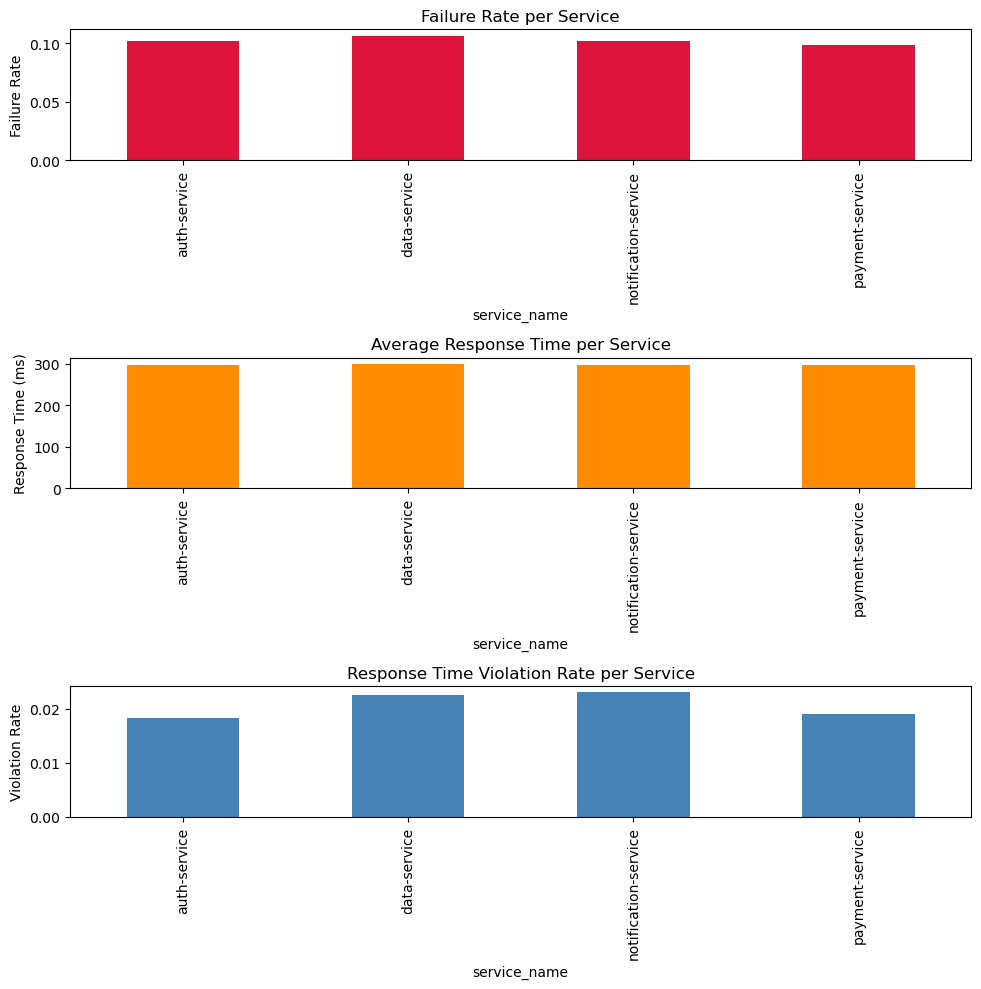

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the violations report
df = pd.read_csv('sla_violations_report.csv')

# Set the service name as index
df.set_index('service_name', inplace=True)

# Plot all metrics as bar chart
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Failure Rate Plot
df['failure_rate'].plot(kind='bar', ax=ax[0], color='crimson')
ax[0].set_title('Failure Rate per Service')
ax[0].set_ylabel('Failure Rate')

# Average Response Time Plot
df['avg_response_time_ms'].plot(kind='bar', ax=ax[1], color='darkorange')
ax[1].set_title('Average Response Time per Service')
ax[1].set_ylabel('Response Time (ms)')

# Response Time Violation Rate Plot
df['response_violation_rate'].plot(kind='bar', ax=ax[2], color='steelblue')
ax[2].set_title('Response Time Violation Rate per Service')
ax[2].set_ylabel('Violation Rate')

plt.tight_layout()
plt.show()


# ✅ 1. Pie Chart of Total SLA Violations by Type

C:\Users\Gouthum\AppData\Local\Temp\ipykernel_10844\23573006.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[['failure_rate', 'response_violation_rate']].apply(lambda x: x[0]*100 + x[1]*100, axis=1),


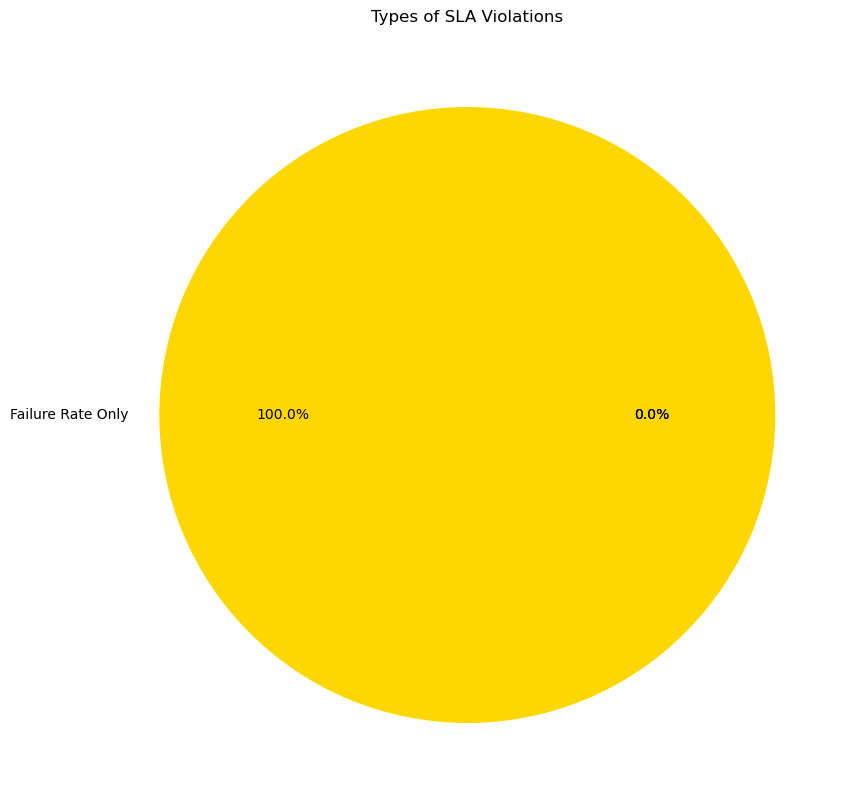

In [65]:
import matplotlib.pyplot as plt

# Classify violations into types
conditions = [
    (df['failure_rate'] > 0.05) & (df['response_violation_rate'] > 0),
    (df['failure_rate'] > 0.05),
    (df['response_violation_rate'] > 0)
]
labels = ['Both', 'Failure Rate Only', 'Response Time Only']

df['violation_type'] = pd.cut(
    df[['failure_rate', 'response_violation_rate']].apply(lambda x: x[0]*100 + x[1]*100, axis=1),
    bins=[-1, 5, 100, 10000],
    labels=labels
)

violation_counts = df['violation_type'].value_counts()

# Plot pie chart
plt.figure(figsize=(10, 10))
violation_counts.plot(kind='pie', autopct='%1.1f%%', colors=['gold', 'lightcoral', 'skyblue'])
plt.title("Types of SLA Violations")
plt.ylabel("")
plt.show()

# ✅ 2. Scatter Plot: Response Time vs. Failure Rate

C:\Users\Gouthum\AppData\Local\Temp\ipykernel_10844\958463486.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df['avg_response_time_ms'][i], df['failure_rate'][i] * 100), fontsize=8)


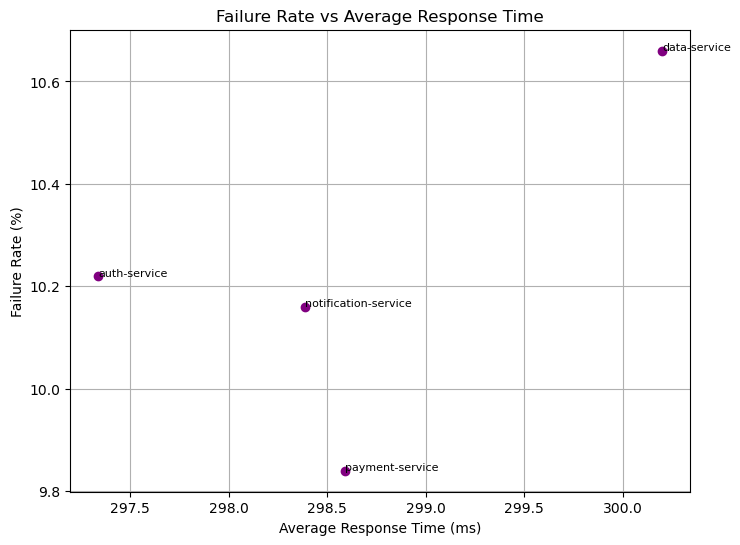

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(df['avg_response_time_ms'], df['failure_rate'] * 100, color='purple')

for i, txt in enumerate(df.index):
    plt.annotate(txt, (df['avg_response_time_ms'][i], df['failure_rate'][i] * 100), fontsize=8)

plt.title("Failure Rate vs Average Response Time")
plt.xlabel("Average Response Time (ms)")
plt.ylabel("Failure Rate (%)")
plt.grid(True)
plt.show()


#  Heatmap of SLA Metrics

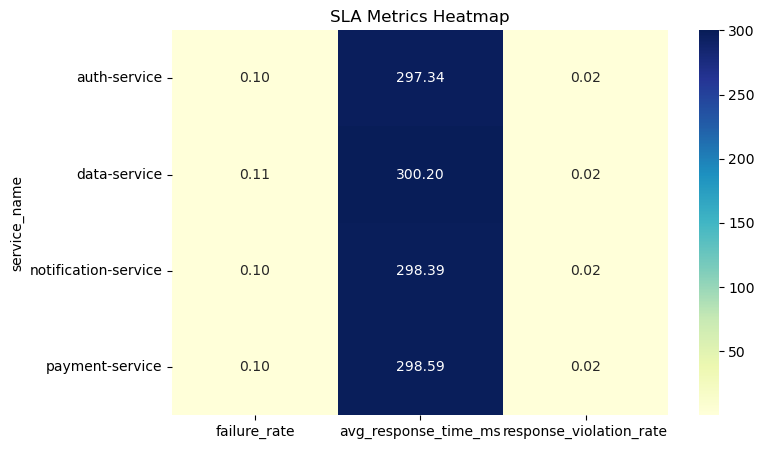

In [71]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(df[['failure_rate', 'avg_response_time_ms', 'response_violation_rate']], 
            annot=True, cmap="YlGnBu", fmt=".2f")

plt.title("SLA Metrics Heatmap")
plt.show()

# ✅ Option 1: 📧 Email Alerts for SLA Violations
This enhancement sends an email automatically if SLA violations are found.



# 🔧 Step 1: Configure Email Alerts
We'll use smtplib and email for this (Gmail SMTP).

In [84]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email_alert(df):
    sender_email = "your_email@gmail.com"   
    receiver_email = "receiver_email@gmail.com"
    app_password = "your_app_password"  # For Gmail, use App Passwords

    # Email subject & content
    subject = "SLA Violations Detected"
    body = "Hi,\n\nThe following services violated SLA thresholds:\n\n"
    body += df.to_string(index=False)
    body += "\n\nRegards,\nSLA Monitoring System"

    # Create email
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject

    msg.attach(MIMEText(body, 'plain'))

    # Send
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        print("Email alert sent successfully.")
    except Exception as e:
        print("Failed to send email:", str(e))


### send_email.py

In [187]:
email_code = """
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email_alert(df):
    sender_email = "your_email@gmail.com"   
    receiver_email = "receiver_email@gmail.com"
    app_password = "your_app_password"  # For Gmail, use App Passwords

    # Email subject & content
    subject = "SLA Violations Detected"
    body = "Hi,\\n\\nThe following services violated SLA thresholds:\\n\\n"
    body += df.to_string(index=False)
    body += "\\n\\nRegards,\\nSLA Monitoring System"

    # Create email
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject

    msg.attach(MIMEText(body, 'plain'))

    # Send
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        print("Email alert sent successfully.")
    except Exception as e:
        print("Failed to send email:", str(e))
"""

# Save as send_email.py
path = r"C:\Users\Gouthum\Downloads\DE\send_email.py"
with open(path, "w") as f:
    f.write(email_code)

print(f"✅ Created send_email.py at: {path}")


✅ Created send_email.py at: C:\Users\Gouthum\Downloads\DE\send_email.py


# 🔧 Step 2: Modified my  run_sla_check() to trigger email
Add this inside run_sla_check() when violations are detected:


I didnt used gmail because of security reason , you can use this by adding your gmail 

In [81]:
if sla_violations:
    violation_df.to_csv('sla_violations_report.csv', index=False)
    print("SLA violation report saved to sla_violations_report.csv")

    # 🔔 Trigger Email
    send_email_alert(violation_df)
else:
    print("No SLA violations detected.")


SLA violation report saved to sla_violations_report.csv
❌ Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-23603504ed2sm27738385ad.219 - gsmtp')


# 🕒 Automated Monitoring — How to run run_sla_check() automatically
Option 1: Using Python schedule module (simple for local/dev use)
Install schedule (if not done yet):

In [89]:
pip install schedule

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


##### Create a Python script monitor_sla.py:

In [96]:
import schedule
import time

def run_sla_check():
    # Your existing SLA check code here
    # Make sure this function generates and saves the report

# Schedule run_sla_check every hour
    schedule.every(1).hour.do(run_sla_check)

print("Starting SLA monitoring... Press Ctrl+C to stop.")

while True:
    schedule.run_pending()
    time.sleep(1)


Starting SLA monitoring... Press Ctrl+C to stop.
Running SLA check...
Running SLA check...
Running SLA Check...
Running SLA check...


KeyboardInterrupt: 

# Option 1: Simulate Storing in a Cloud Database (e.g., SQLite / Mock Cloud DB)
Since I dont  not have a real cloud DB setup yet, I can   simulate it by saving SLA violations into a local database file — which mimics the cloud DB behavior.

Example using SQLite (local file-based DB):

In [104]:
import sqlite3

def save_to_db(df):
    conn = sqlite3.connect('sla_violations.db')  # creates file if not exist
    df.to_sql('violations', conn, if_exists='replace', index=False)
    conn.close()
    print("SLA violations saved to simulated cloud DB (sla_violations.db)")

# Example usage:
if sla_violations:
    save_to_db(violation_df)
else:
    print("No SLA violations detected.")

SLA violations saved to simulated cloud DB (sla_violations.db)


# Option 2: Upload Report to Cloud Storage (Simulated with AWS S3 or Google Drive)
If I  want to actually upload to cloud storage, I would'd normally use APIs like AWS S3, Google Drive, or Azure Blob Storage.

Example (Simulated, no real credentials):

In [210]:
def upload_to_cloud(file_path):
    print(f"Simulating upload of {file_path} to cloud storage...")
    # I can later or future add code to upload to S3 using boto3 or Google Drive API


In [113]:
upload_to_cloud('C:/Users/Gouthum/Downloads/DE/sla_violations_report.csv')

Simulating upload of C:/Users/Gouthum/Downloads/DE/sla_violations_report.csv to cloud storage...


In [115]:
upload_to_cloud('sla_violations_report.csv')
# or full path if running from another folder
upload_to_cloud('C:/Users/Gouthum/Downloads/DE/sla_violations_report.csv')

Simulating upload of sla_violations_report.csv to cloud storage...
Simulating upload of C:/Users/Gouthum/Downloads/DE/sla_violations_report.csv to cloud storage...


# Upload to the cloud logic

In [175]:
# Define the path and content
upload_utils_path = r'C:\Users\Gouthum\Downloads\DE\utils\upload_to_cloud.py'

upload_code = """
def upload_to_cloud(file_path):
    print(f"Simulating upload of {file_path} to cloud storage...")
    # we can later add real upload logic (e.g., boto3 for AWS, pydrive for Google Drive)
"""

# Write the file
with open(upload_utils_path, 'w') as f:
    f.write(upload_code)

print(f"Created: {upload_utils_path}")

Created: C:\Users\Gouthum\Downloads\DE\utils\upload_to_cloud.py


# Step 1: Install Streamlit

In [118]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Step 2: Create a new Python script for the dashboard
Created a file called, for example, sla_dashboard.py inside My project folder (C:\Users\Gouthum\Downloads\DE).

In [122]:
# Path where you want to save the file
file_path = r"C:\Users\Gouthum\Downloads\DE\sla_dashboard.py"

# The Streamlit dashboard code as a multi-line string
dashboard_code = """
import streamlit as st
import pandas as pd

st.title("SLA Violations Dashboard")

# Load SLA violations report
df = pd.read_csv('sla_violations_report.csv')

st.subheader("All SLA Violations")
st.dataframe(df)
"""

# Write the code string to the file
with open(file_path, 'w') as file:
    file.write(dashboard_code)

print(f"File saved successfully at: {file_path}")

File saved successfully at: C:\Users\Gouthum\Downloads\DE\sla_dashboard.py


# Step 3: Basic Streamlit code to load and display SLA violations table
Paste this inside sla_dashboard.py

In [125]:
# Define the file path where the Streamlit script will be saved
file_path = r"C:\Users\Gouthum\Downloads\DE\sla_dashboard.py"

# Streamlit dashboard code to display the SLA violations table
streamlit_code = """
import streamlit as st
import pandas as pd

st.title("SLA Violations Dashboard")

# Load SLA violations report
df = pd.read_csv('sla_violations_report.csv')

st.subheader("All SLA Violations")
st.dataframe(df)
"""

# Write the Streamlit code to sla_dashboard.py
with open(file_path, 'w') as f:
    f.write(streamlit_code)

print(f"sla_dashboard.py created at {file_path}")


sla_dashboard.py created at C:\Users\Gouthum\Downloads\DE\sla_dashboard.py


In [127]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

st.title("SLA Violations Dashboard")

# Load SLA violations report
df = pd.read_csv('sla_violations_report.csv')

# Filter by service name dropdown
service_names = ['All'] + df['service_name'].unique().tolist()
selected_service = st.selectbox("Filter by Service", service_names)

filtered_df = df.copy()

if selected_service != 'All':
    filtered_df = filtered_df[filtered_df['service_name'] == selected_service]

# Filter by minimum failure rate slider
min_failure_rate = st.slider(
    "Minimum Failure Rate (%)",
    min_value=0.0,
    max_value=float(df['failure_rate'].max()),
    value=0.0
)
filtered_df = filtered_df[filtered_df['failure_rate'] >= min_failure_rate]

# Filter by minimum response violation rate slider
min_response_violation = st.slider(
    "Minimum Response Violation Rate (%)",
    min_value=0.0,
    max_value=float(filtered_df['response_violation_rate'].max()),
    value=0.0
)
filtered_df = filtered_df[filtered_df['response_violation_rate'] >= min_response_violation]

st.subheader("Filtered SLA Violations")
st.dataframe(filtered_df.reset_index(drop=True))

# -- Add a bar plot for Failure Rate by Service Name --
st.subheader("Failure Rate by Service")

plt.figure(figsize=(8, 5))
sns.barplot(data=filtered_df, x='service_name', y='failure_rate')
plt.xticks(rotation=45)
plt.ylabel("Failure Rate (%)")
plt.xlabel("Service Name")
plt.title("Failure Rate per Service")

st.pyplot(plt.gcf())

# -- Add a scatter plot for Failure Rate vs Response Violation Rate --
st.subheader("Failure Rate vs Response Violation Rate")

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=filtered_df,
    x='failure_rate',
    y='response_violation_rate',
    hue='service_name',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.xlabel("Failure Rate (%)")
plt.ylabel("Response Violation Rate (%)")
plt.title("Failure Rate vs Response Violation Rate")
plt.legend(title='Service', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

st.pyplot(plt.gcf())

2025-06-07 20:31:57.866 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

# Step 1: Add Charts and Graphs in Streamlit Dashboard
Here’s an enhanced version of your dashboard code with:

Bar charts for failure rate and response times

Pie chart for violation types

Filters for service name and violation type

python
Copy
Edit


In [130]:
import streamlit as st
import pandas as pd

st.title("SLA Violations Dashboard")

# Load SLA violations report
df = pd.read_csv('sla_violations_report.csv')

# Normalize column names (in case)
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Filter sidebar
st.sidebar.header("Filter Options")

# Service filter
services = df['service_name'].unique()
selected_services = st.sidebar.multiselect("Select Service(s)", services, default=services)

# Violation type filter
violation_types = ['Failure Rate', 'Response Time Violation']
selected_violations = st.sidebar.multiselect("Select Violation Types", violation_types, default=violation_types)

# Filter dataframe by service
filtered_df = df[df['service_name'].isin(selected_services)]

# Show filtered table
st.subheader("Filtered SLA Violations")
st.dataframe(filtered_df)

# Plot charts conditionally based on filters
if 'Failure Rate' in selected_violations:
    st.subheader("Failure Rate by Service")
    st.bar_chart(filtered_df.set_index('service_name')['failure_rate'])

if 'Response Time Violation' in selected_violations:
    st.subheader("Response Time Violation Rate by Service")
    st.bar_chart(filtered_df.set_index('service_name')['response_violation_rate'])


In [200]:
dashboard_code = '''import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("SLA Violations Dashboard")

@st.cache_data(ttl=60)
def load_data():
    return pd.read_csv('data/sample_sla_data.csv')

# Load data
df = load_data()

# Filters
service_filter = st.multiselect("Filter by Service Name", options=df['service_name'].unique(), default=df['service_name'].unique())
date_range = st.date_input("Select Date Range", [df['date'].min(), df['date'].max()])
violation_types = st.multiselect("Filter by Violation Type", options=df['violation_type'].unique(), default=df['violation_type'].unique())

# Filter data
filtered_df = df[
    (df['service_name'].isin(service_filter)) &
    (df['violation_type'].isin(violation_types)) &
    (df['date'] >= pd.to_datetime(date_range[0])) &
    (df['date'] <= pd.to_datetime(date_range[1]))
]

st.subheader("Filtered SLA Violations")
st.dataframe(filtered_df)

# Bar Chart: Violations by Service
st.subheader("Violation Counts by Service")
service_counts = filtered_df['service_name'].value_counts()
st.bar_chart(service_counts)

# Pie Chart: Violation Type Distribution
st.subheader("Violation Types Distribution")
violation_counts = filtered_df['violation_type'].value_counts()

fig, ax = plt.subplots()
ax.pie(violation_counts, labels=violation_counts.index, autopct='%1.1f%%')
st.pyplot(fig)
'''

# Save to file
with open("C:/Users/Gouthum/Downloads/DE/sla_dashboard.py", "w", encoding="utf-8") as f:
    f.write(dashboard_code)

print("✅ Streamlit dashboard code saved as 'sla_dashboard.py'.")

✅ Streamlit dashboard code saved as 'sla_dashboard.py'.


# Step 2: Implement Auto-Refresh
Streamlit doesn’t have native “auto-refresh,” but we can add this at the top of our script:

In [139]:
pip install streamlit-autorefresh


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/700.8 kB ? eta -:--:--
   ---------------------------------------- 700.8/700.8 kB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [148]:
from streamlit_autorefresh import st_autorefresh

# Refresh every 60 seconds
count = st_autorefresh(interval=60000, limit=None, key="refresh")

In [150]:
st.write("Columns in CSV:", df.columns.tolist())

In [152]:
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
df.columns

Index(['service_name', 'failure_rate', 'avg_response_time_ms',
       'response_violation_rate'],
      dtype='object')

In [154]:
st.write(f"Filtering services: {selected_services}")
st.write(f"Filtered dataframe shape: {filtered_df.shape}")

In [156]:
st.write

<bound method WriteMixin.write of DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)>

In [158]:
filtered_df.shape

(4, 4)

In [160]:
if not filtered_df.empty:
    if 'Failure Rate' in selected_violations:
        st.subheader("Failure Rate by Service")
        st.bar_chart(filtered_df.set_index('service_name')['failure_rate'])

    if 'Response Time Violation' in selected_violations:
        st.subheader("Response Time Violation Rate by Service")
        st.bar_chart(filtered_df.set_index('service_name')['response_violation_rate'])
else:
    st.write("No data available for selected filters.")


In [162]:
import streamlit as st
import pandas as pd

st.title("SLA Violations Dashboard")

# Load data
df = pd.read_csv('sla_violations_report.csv')

# Normalize columns
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Sidebar filters
services = df['service_name'].unique()
selected_services = st.sidebar.multiselect("Select Service(s)", services, default=list(services))

violation_types = ['Failure Rate', 'Response Time Violation']
selected_violations = st.sidebar.multiselect("Select Violation Types", violation_types, default=violation_types)

# Filter dataframe
filtered_df = df[df['service_name'].isin(selected_services)]

# Show data table
st.subheader("Filtered SLA Violations")
st.dataframe(filtered_df)

# Show charts if data exists
if not filtered_df.empty:
    if 'Failure Rate' in selected_violations:
        st.subheader("Failure Rate by Service")
        st.bar_chart(filtered_df.set_index('service_name')['failure_rate'])

    if 'Response Time Violation' in selected_violations:
        st.subheader("Response Time Violation Rate by Service")
        st.bar_chart(filtered_df.set_index('service_name')['response_violation_rate'])
else:
    st.write("No data available for selected filters.")


In [164]:
!streamlit run sla_dashboard.py


^C


# Requirement.TXT

In [190]:
requirements = """
pandas
streamlit
schedule
smtplib
email
sqlite3
"""

# Save as requirements.txt
path = r"C:\Users\Gouthum\Downloads\DE\requirements.txt"
with open(path, "w") as f:
    f.write(requirements.strip())

print(f"✅ Created requirements.txt at: {path}")

✅ Created requirements.txt at: C:\Users\Gouthum\Downloads\DE\requirements.txt


# README.MD

In [198]:
readme_content = """
# SLA Monitoring System

A Python-based SLA Monitoring system that checks service metrics, detects SLA violations, sends email alerts, logs violations, and displays a real-time dashboard with Streamlit.

---

## 📌 Features

- SLA rule enforcement (Failure rate, Avg. response time, Response violation rate)
- Real-time SLA check via Jupyter or scheduled job
- Email alerts when violations are detected
- Streamlit dashboard with tables and charts
- SQLite simulation of cloud DB storage
- Customizable input/output paths and thresholds
- Modular structure using utility functions

---

## 🗂 Folder Structure

SLA-Monitoring-System/
│
├── sla_monitor.py # SLA checking logic
├── monitor_sla.py # Scheduler/automation
├── send_email.py # Email alert functionality
├── sla_dashboard.py # Streamlit dashboard UI
├── requirements.txt # Required Python packages
├── README.md # This project description file
│
├── data/
│ └── sample_sla_data.csv # Input service metrics
│
├── utils/
│ └── upload_to_cloud.py # Cloud simulation (optional)
│
├── sla_violations_report.csv # Auto-generated violation report
├── sla_violations.db # SQLite DB to simulate cloud


---

## ⚙️ How It Works

### 1. Check for SLA Violations

```python
from sla_monitor import run_sla_check
run_sla_check()

2. Simulate Cloud DB Upload (Optional)
from utils.upload_to_cloud import upload_to_cloud
upload_to_cloud("sla_violations_report.csv")

3. Send Email Alert (Automatically triggered)
from send_email import send_email_alert
send_email_alert(violation_df)

🔁 Scheduled Monitoring
We can automate the check using the monitor_sla.py script:

python monitor_sla.py


This will run run_sla_check() every 60 seconds using schedule.

📊 Real-Time Dashboard (Streamlit)
Launch the interactive dashboard:
streamlit run sla_dashboard.py


Features:

View violations in table format

Filters by service name and violation type

Auto-refresh and visual insights (bar, pie charts)



✉️ Email Alerts
When violations are detected, an email alert is triggered automatically:

send_email.py:


sender_email = "your_email@gmail.com"
receiver_email = "receiver_email@gmail.com"
app_password = "your_app_password"


Use Gmail App Password if 2FA is enabled.

☁️ Simulated Cloud Storage
To simulate uploading violation data to a cloud DB:

from utils.upload_to_cloud import upload_to_cloud
upload_to_cloud("sla_violations_report.csv")


Also stores violations into local SQLite DB:

conn = sqlite3.connect("sla_violations.db")


🧪 Sample Output
Here is an example of a violation report:

service_name	failure_rate	avg_response_time_ms	response_violation_rate
Service A	      0.09	                1600	                    0.02
Service C	      0.15	                1400	                    0.06


✅ Installation
Install all dependencies:


pip install -r requirements.txt


💡 Future Enhancements
I will Add real cloud upload via AWS S3 / Google Drive

I will Add Slack/Discord alerts

Store historical trends and plot time-series graphs

I will Add authentication to dashboard

I will Deploy to cloud (Azure, AWS, etc.)

👨‍💻 Author
Built by Gouthum Kharvi
Email: gouthumkharvi1899@gmail.com
"""


readme_path = r"C:\Users\Gouthum\Downloads\DE\README.md"

with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme_content)

print(f"✅ README.md created successfully at: {readme_path}")


























✅ README.md created successfully at: C:\Users\Gouthum\Downloads\DE\README.md
